In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import cv2
import sklearn
import PIL
import torch
import torchvision
from matplotlib import cm

import warnings
warnings.filterwarnings('ignore')

### Зачем
- Посмотрим, как проводится операция свертки;
- Посмотрим, как работает pooling;
- Попробуем собрать сверточную нейронную сеть на PyTorch

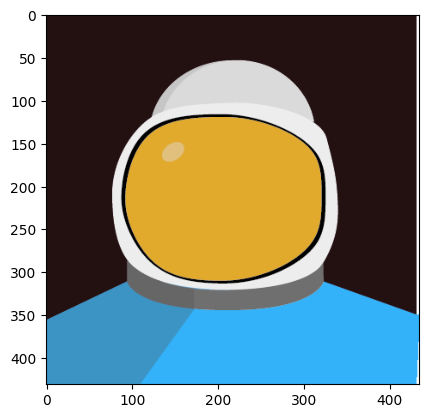

In [ ]:
image = cv2.imread('./image.png')
plt.imshow(image);

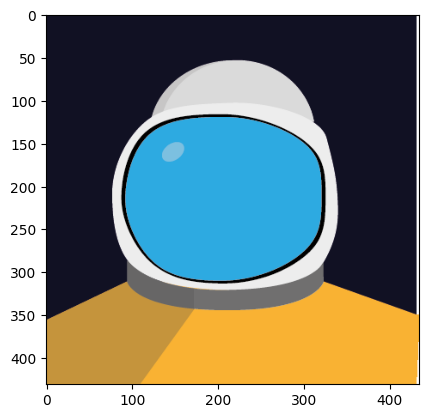

In [ ]:
image_ex = image[...,::-1]
plt.imshow(image_ex)

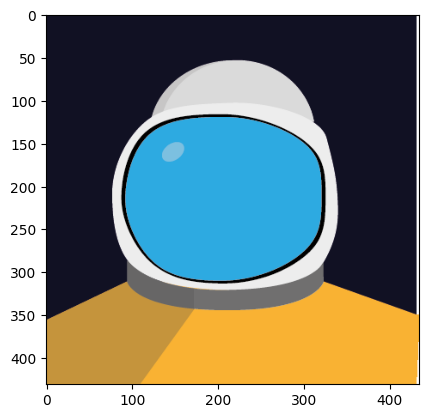

In [ ]:
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb);

Посмотрим на каналы изображения отдельно

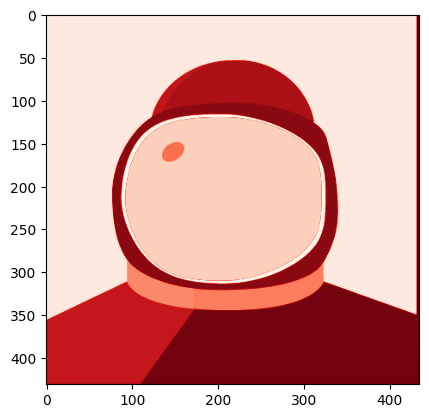

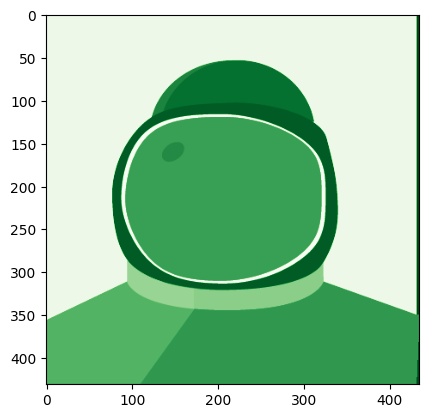

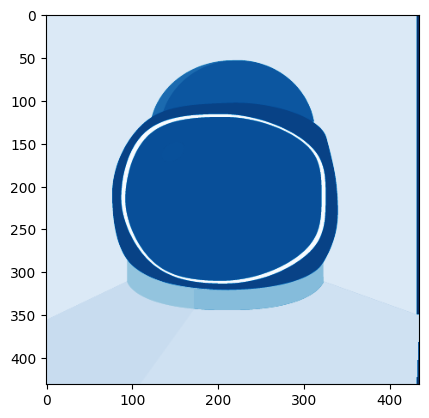

In [ ]:
img_mat = np.array(image_rgb)
plt.imshow(img_mat[:, :, 0], cmap=cm.Reds)
plt.show()

img_mat = np.array(image_rgb)
plt.imshow(img_mat[:, :, 1], cmap=cm.Greens)
plt.show()

img_mat = np.array(image_rgb)
plt.imshow(img_mat[:, :, 2], cmap=cm.Blues)
plt.show()

# Операция свертки

- Количество входных каналов `in_channels`
- Количество выходных каналов `out_channels`
- Размер ядра `kernel_size`
- Шаг `stride`
- Паддинг `padding`
- Режим паддинга `padding_mode` (`'zeros'`, `'reflect'`, ...)
![alt text](conv.png "")

In [ ]:
bw_image = cv2.imread('./image.png', cv2.IMREAD_GRAYSCALE)

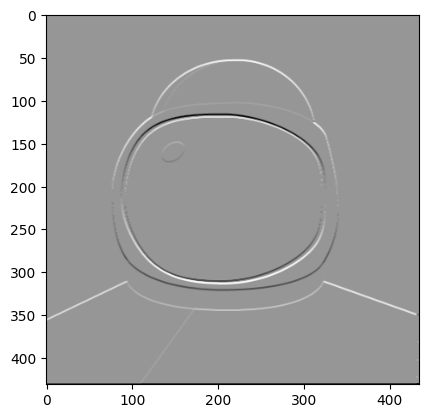

In [ ]:
from scipy.signal import convolve2d

G_y = np.array([
    [1, 2, 1],
    [0, 0, 0],
    [-1, -2, -1]
])

res_y = convolve2d(bw_image, G_y, "same")
plt.imshow(res_y, cmap=plt.cm.Greys_r)

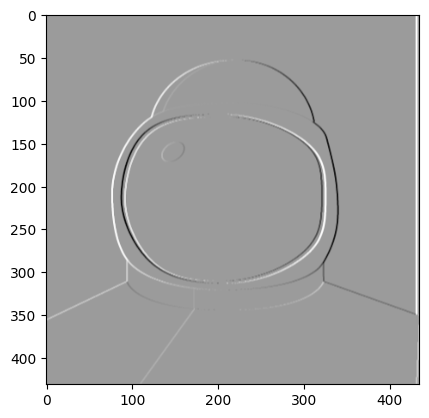

In [ ]:
G_x = np.array([
    [-1, 0, 1],
    [-2, 0, 2],
    [-1, 0, 1]
])

res_x = convolve2d(bw_image, G_y.T, "same")
plt.imshow(res_x, cmap=plt.cm.Greys_r)

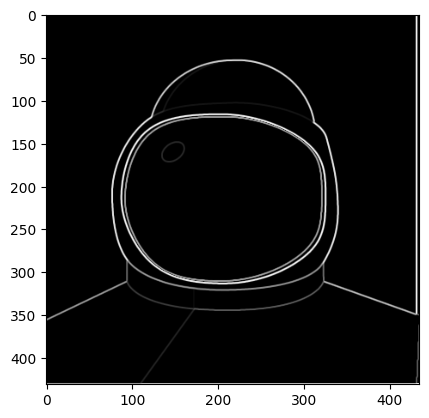

In [ ]:
res_sobel = (res_x**2 + res_y**2)**0.5
plt.imshow(res_sobel, cmap=plt.cm.Greys_r)

# Пулинг

In [ ]:
import numpy as np

conv_output = np.array([
    [10, 12,  8,  7],
    [ 4, 11,  5,  9],
    [18, 13,  7,  7],
    [ 3, 15,  2,  2]
])
conv_output

array([[10, 12,  8,  7],
       [ 4, 11,  5,  9],
       [18, 13,  7,  7],
       [ 3, 15,  2,  2]])

Сначала попробуем со `stride=2`

![alt text](pool.png "")

In [ ]:
pool_size = 2
stride = 2

def get_pools(img=conv_output, pool_size=2, stride=2):

    pools = []
    for i in np.arange(conv_output.shape[0], step=stride):
        for j in np.arange(conv_output.shape[0], step=stride):
            mat = conv_output[i:i+pool_size, j:j+pool_size]
            pools.append(mat)
    pools = np.array(pools)
    return pools

pools = get_pools()
pools

array([[[10, 12],
        [ 4, 11]],

       [[ 8,  7],
        [ 5,  9]],

       [[18, 13],
        [ 3, 15]],

       [[ 7,  7],
        [ 2,  2]]])

In [ ]:
def max_pooling(pools: np.array) -> np.array:

    num_pools = pools.shape[0]

    # Размер матрицы после пулинга
    tgt_shape = (int(np.sqrt(num_pools)), int(np.sqrt(num_pools)))

    # Здесь будем хранить максимумы с каждого из пулов
    pooled = []
    for pool in pools:
        pooled.append(np.max(pool))

    return np.array(pooled).reshape(tgt_shape)

In [ ]:
max_pooling(pools=pools)

array([[12,  9],
       [18,  7]])

# Сверточная нейронная сеть

In [ ]:
import torch
import torch.nn.functional as F
import torchvision
from torch import nn
from tqdm import tqdm

In [ ]:
transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081,))
    ]
)

In [ ]:
mnist_train = torchvision.datasets.MNIST(
    './mnist/',
    train=True,
    download=True,
    transform=transform
)

mnist_val = torchvision.datasets.MNIST(
    './mnist/',
    train=False,
    download=True,
    transform=transform
)

train_dataloader = torch.utils.data.DataLoader(mnist_train, batch_size=64, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(mnist_val, batch_size=64, shuffle=True)

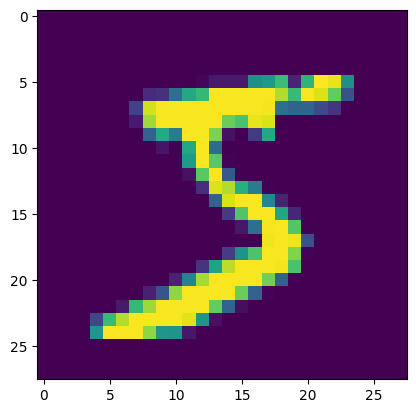

In [ ]:
plt.imshow(mnist_train[0][0].squeeze(0).numpy().reshape([28, 28]))

In [ ]:
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
)

optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [ ]:
def train(model, optimizer, n_epochs=5):
    for epoch in range(n_epochs):

        # обучение
        for x_train, y_train in tqdm(train_dataloader):
            y_pred = model(x_train)
            loss = F.cross_entropy(y_pred, y_train)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        # валидация
        if epoch % 2 == 0:
            val_loss = []
            val_accuracy = []
            with torch.no_grad():
                for x_val, y_val in tqdm(val_dataloader):
                    y_pred = model(x_val)
                    loss = F.cross_entropy(y_pred, y_val)
                    val_loss.append(loss.numpy())
                    val_accuracy.extend((torch.argmax(y_pred, dim=-1) == y_val).numpy().tolist())

            print(f'Epoch: {epoch}, loss: {np.mean(val_loss)}, accuracy: {np.mean(val_accuracy)}')

In [ ]:
train(model, optimizer)

100%|██████████| 157/157 [00:03<00:00, 42.68it/s]


Epoch: 0, loss: 0.32209059596061707, accuracy: 0.911


100%|██████████| 157/157 [00:03<00:00, 48.67it/s]


Epoch: 2, loss: 0.2268231362104416, accuracy: 0.9345


100%|██████████| 157/157 [00:02<00:00, 58.40it/s]

Epoch: 4, loss: 0.18372580409049988, accuracy: 0.9479


In [ ]:
model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5),  # grayscale
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=4),   # сократим изображение в 4 раза по каждой из сторон
    nn.Flatten(),
    nn.Linear(6*6*10, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
)

optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [ ]:
train(model, optimizer)

  4%|▎         | 34/938 [00:01<00:37, 23.92it/s]


KeyboardInterrupt: ignored

# Домашнее задание

Обучите сверточную нейронную сеть на датасете MNIST, взяв любой другой оптимизатор (кроме SGD) и любую другую функцию ошибки (кроме cross-entropy loss). Попробуйте поварьировать параметры: кол-во ядер, `kernel_size` и побить текущий бейзлайн в `0.9746`. Выведите количество обучаемых параметров.    
Какого качества удалось достичь? Попробуйте залоггировать Ваши результаты - построить графики того, как менялись метрики качества (accuracy, loss) с течением эпох, включить логгирование, сравнить результаты между собой при разных параметрах.

Любые дополнительные улучшения (как по методам, так и по коду пайплайна) приветствуются!

*Цель:* выработать навык обучения нейронных сетей (в частности сверточных) на основе средств PyTorch, начиная от загрузки датасетами и заканчивая выводами результатов, их логгированием, сравнением и анализом.

## Оптимизатор Adadelta

In [ ]:
optimizer = torch.optim.Adadelta(model.parameters())

In [ ]:
train(model, optimizer)

100%|██████████| 157/157 [00:04<00:00, 37.38it/s]


Epoch: 0, loss: 0.1774229258298874, accuracy: 0.941


100%|██████████| 157/157 [00:04<00:00, 36.59it/s]


Epoch: 2, loss: 0.0652615949511528, accuracy: 0.9776


100%|██████████| 157/157 [00:04<00:00, 38.87it/s]

Epoch: 4, loss: 0.03230859339237213, accuracy: 0.9875


## Функции потерь

In [ ]:
def reset_model(model):
    for layer in model.children():
        if hasattr(layer, 'reset_parameters'):
            layer.reset_parameters()

In [ ]:
def train_with_loss(model, optimizer, n_epochs=5, loss = None):
    if loss is None:
        loss = F.cross_entropy

    for epoch in range(n_epochs):

        # обучение
        for x_train, y_train in tqdm(train_dataloader):
            y_pred = model(x_train)
            loss_batch = loss(y_pred, y_train)
            loss_batch.backward()
            optimizer.step()
            optimizer.zero_grad()

        # валидация
        if epoch % 2 == 0:
            val_loss = []
            val_accuracy = []
            with torch.no_grad():
                for x_val, y_val in tqdm(val_dataloader):
                    y_pred = model(x_val)
                    loss_batch = loss(y_pred, y_val)
                    val_loss.append(loss_batch.numpy())
                    val_accuracy.extend((torch.argmax(y_pred, dim=-1) == y_val).numpy().tolist())

            print(f'Epoch: {epoch}, loss: {np.mean(val_loss)}, accuracy: {np.mean(val_accuracy)}')

multi_margin_loss

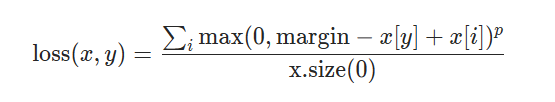

In [ ]:
train_with_loss(model, optimizer, loss = F.multi_margin_loss)

100%|██████████| 157/157 [00:03<00:00, 48.98it/s]


Epoch: 0, loss: 0.004295528866350651, accuracy: 0.9865


100%|██████████| 157/157 [00:03<00:00, 48.78it/s]


Epoch: 2, loss: 0.00476046372205019, accuracy: 0.987


100%|██████████| 157/157 [00:03<00:00, 48.44it/s]

Epoch: 4, loss: 0.0035075913183391094, accuracy: 0.9902


Количество обучаемых параметров

In [ ]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {total_params}")

Number of trainable parameters: 47758


## Логирование

In [ ]:
from IPython.display import clear_output
def train_with_plot(model, optimizer, n_epochs=5, loss = None, plot=True):
    if loss is None:
        loss = F.cross_entropy

    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []

    for epoch in range(n_epochs):
        losses = []
        accuracies = []
        # обучение
        for x_train, y_train in tqdm(train_dataloader):
            y_pred = model(x_train)
            loss_batch = loss(y_pred, y_train)
            loss_batch.backward()
            optimizer.step()
            optimizer.zero_grad()
            losses.append(loss_batch.detach().numpy())
            accuracies.extend((torch.argmax(y_pred, dim=-1) == y_train).numpy().tolist())

        train_loss_epochs.append(np.mean(losses))
        train_accuracy_epochs.append(np.mean(accuracies))

        # валидация
        losses = []
        accuracies = []
        with torch.no_grad():
            for x_val, y_val in tqdm(val_dataloader):
                y_pred = model(x_val)
                loss_batch = loss(y_pred, y_val)
                losses.append(loss_batch.numpy())
                accuracies.extend((torch.argmax(y_pred, dim=-1) == y_val).numpy().tolist())
        test_loss_epochs.append(np.mean(losses))
        test_accuracy_epochs.append(np.mean(accuracies))

        clear_output(True)
        if plot:
            plt.figure(figsize=(12, 5))
            plt.subplot(1, 2, 1)
            plt.plot(train_loss_epochs, label='Train')
            plt.plot(test_loss_epochs, label='Test')
            plt.xlabel('Epochs', fontsize=16)
            plt.ylabel('Loss', fontsize=16)
            plt.legend(loc=0, fontsize=16)
            plt.grid('on')
            plt.subplot(1, 2, 2)
            plt.plot(train_accuracy_epochs, label='Train accuracy')
            plt.plot(test_accuracy_epochs, label='Test accuracy')
            plt.xlabel('Epochs', fontsize=16)
            plt.ylabel('Accuracy', fontsize=16)
            plt.legend(loc=0, fontsize=16)
            plt.grid('on')
            plt.show()
            print(f'Epoch: {epoch}, loss: {np.mean(losses)}, accuracy: {np.mean(accuracies)}')
    return test_loss_epochs, test_accuracy_epochs, train_loss_epochs, train_accuracy_epochs,

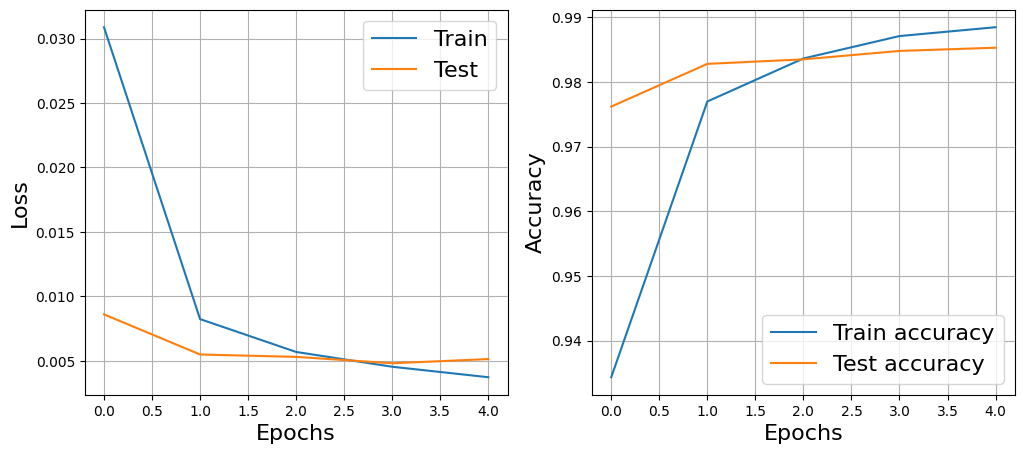

Epoch: 4, loss: 0.0051412018947303295, accuracy: 0.9853


In [ ]:
model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=10, kernel_size=4),  # grayscale
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=4),   # сократим изображение в 4 раза по каждой из сторон
    nn.Flatten(),
    nn.Linear(6*6*10, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
)
optimizer = torch.optim.Adadelta(model.parameters())
train_with_plot(model, optimizer, loss = F.multi_margin_loss)

## Варьирование гиперпараметров

### kernel_size для операции свертки

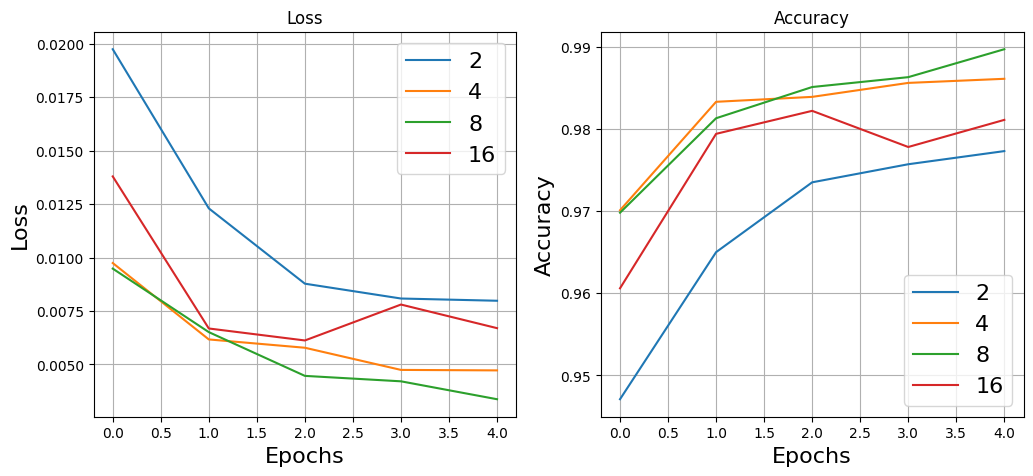

In [ ]:
picture_size = mnist_train[0][0].shape[-1]
def param_model(kernel_size):
  return nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=10, kernel_size=kernel_size),  # grayscale
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=4),   # сократим изображение в 4 раза по каждой из сторон
    nn.Flatten(),
    nn.Linear(((picture_size-kernel_size+1)//4)**2 *10, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
)

model = param_model(2)
optimizer = torch.optim.Adadelta(model.parameters())
ts_loss_2, ts_accuracy_2, _, _ = train_with_plot(model, optimizer, loss = F.multi_margin_loss, plot = False)

model = param_model(4)
optimizer = torch.optim.Adadelta(model.parameters())
ts_loss_4, ts_accuracy_4, _, _ = train_with_plot(model, optimizer, loss = F.multi_margin_loss, plot = False)

model = param_model(8)
optimizer = torch.optim.Adadelta(model.parameters())
ts_loss_8, ts_accuracy_8, _, _ = train_with_plot(model, optimizer, loss = F.multi_margin_loss, plot = False)

model = param_model(16)
optimizer = torch.optim.Adadelta(model.parameters())
ts_loss_16, ts_accuracy_16, _, _ = train_with_plot(model, optimizer, loss = F.multi_margin_loss, plot = False)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(ts_loss_2, label='2')
plt.plot(ts_loss_4, label='4')
plt.plot(ts_loss_8, label='8')
plt.plot(ts_loss_16, label='16')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(ts_accuracy_2, label='2')
plt.plot(ts_accuracy_4, label='4')
plt.plot(ts_accuracy_8, label='8')
plt.plot(ts_accuracy_16, label='16')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.show()

Худшая точность при размере ядра 2. Лучшую точность (99%) дал размер ядра 8. Можно предположить, что при слишком маленьком или большом значении значимые для задачи паттерны плохо улавливаются

### Количество выходных каналов

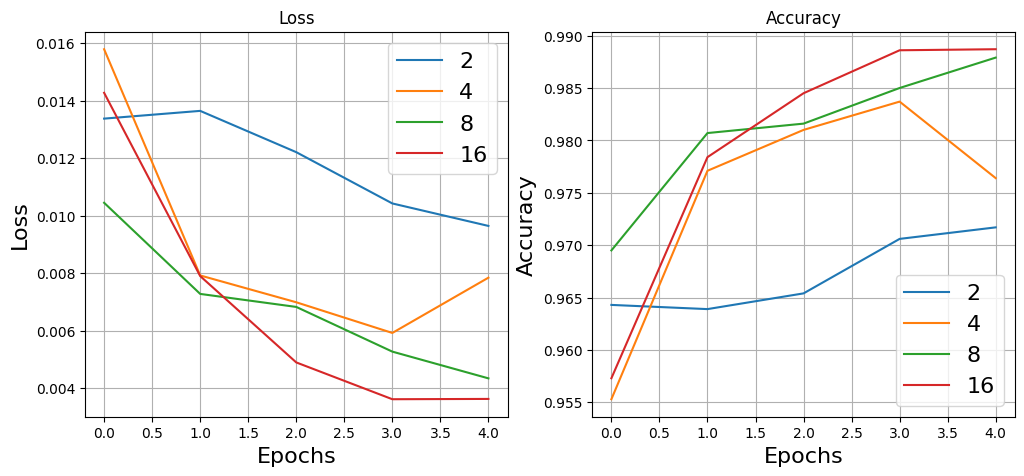

In [ ]:
picture_size = mnist_train[0][0].shape[-1]
def param_model(out_channels):
  return nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=out_channels, kernel_size=8),  # grayscale
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=4),   # сократим изображение в 4 раза по каждой из сторон
    nn.Flatten(),
    nn.Linear(5*5 * out_channels, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
)

model = param_model(2)
optimizer = torch.optim.Adadelta(model.parameters())
ts_loss_2, ts_accuracy_2, _, _ = train_with_plot(model, optimizer, loss = F.multi_margin_loss, plot = False)

model = param_model(4)
optimizer = torch.optim.Adadelta(model.parameters())
ts_loss_4, ts_accuracy_4, _, _ = train_with_plot(model, optimizer, loss = F.multi_margin_loss, plot = False)

model = param_model(8)
optimizer = torch.optim.Adadelta(model.parameters())
ts_loss_8, ts_accuracy_8, _, _ = train_with_plot(model, optimizer, loss = F.multi_margin_loss, plot = False)

model = param_model(16)
optimizer = torch.optim.Adadelta(model.parameters())
ts_loss_16, ts_accuracy_16, _, _ = train_with_plot(model, optimizer, loss = F.multi_margin_loss, plot = False)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(ts_loss_2, label='2')
plt.plot(ts_loss_4, label='4')
plt.plot(ts_loss_8, label='8')
plt.plot(ts_loss_16, label='16')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(ts_accuracy_2, label='2')
plt.plot(ts_accuracy_4, label='4')
plt.plot(ts_accuracy_8, label='8')
plt.plot(ts_accuracy_16, label='16')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.show()

Хуже всего отработало 2 выходных сигнала, лучше всего -- 16. Можно предположить, что слишком малое количество выходных сигналов приводит к худшему результату, т.к. слишком мало уникальных паттернов можно выделить для классификации

### Смотрим на фильтры

In [ ]:
from collections import OrderedDict
model = nn.Sequential(OrderedDict([
    ("conv", nn.Conv2d(in_channels=1, out_channels=16, kernel_size=8)),  # grayscale
    ("relu1", nn.ReLU()),
    ("pool", nn.MaxPool2d(kernel_size=4)),   # сократим изображение в 4 раза по каждой из сторон
    ("flat", nn.Flatten()),
    ("lin1", nn.Linear(5*5 * 16, 128)),
    ("relu2", nn.ReLU()),
    ("lin2", nn.Linear(128, 10))])
)
optimizer = torch.optim.Adadelta(model.parameters())
train_with_plot(model, optimizer, loss = F.multi_margin_loss, plot = False)

([0.0066910563, 0.0065954872, 0.0061313645, 0.0042776293, 0.0033591834],
 [0.9798, 0.9792, 0.9824, 0.9862, 0.9888],
 [0.028922997, 0.007204366, 0.004879447, 0.0039985464, 0.003221703],
 [0.9409666666666666,
  0.9795833333333334,
  0.9851333333333333,
  0.9877666666666667,
  0.98955])

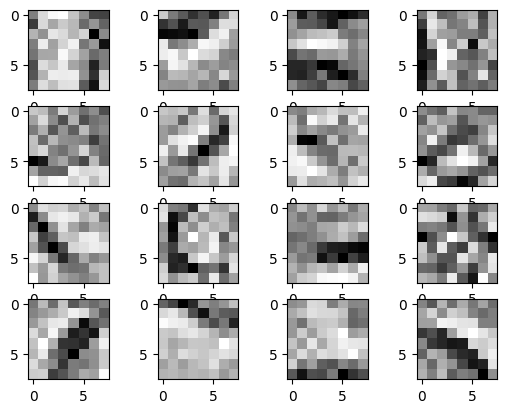

In [ ]:
for i in range(4):
  for j in range(4):
    plt.subplot(4, 4, 4*i+j+1)
    plt.imshow(model.conv.weight[4*i+j].squeeze(0).detach().numpy().reshape([8,8]),cm.Greys)